#SVAR 기반 테슬라 주가 예측 코드 (Cholesky 분해 방식)

1. 제약 조건이 있는 SVAR 모델을 직접 구성  
statsmodels.tsa.api.VAR을 사용하여 일반적인 VAR 모델을 학습한 후 구조적 제약을 반영하여 변수를 조정하는 방식 적용

2. Cholesky 분해를 이용한 구조적 SVAR 근사  
 chol_decomp = np.linalg.cholesky(cov_matrix)  
 Cholesky 분해를 이용해 구조적 충격 반응을 분석할 수 있음

[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


✅ 최적의 차수 (p): 5
📌 Test MSE: 396.1479


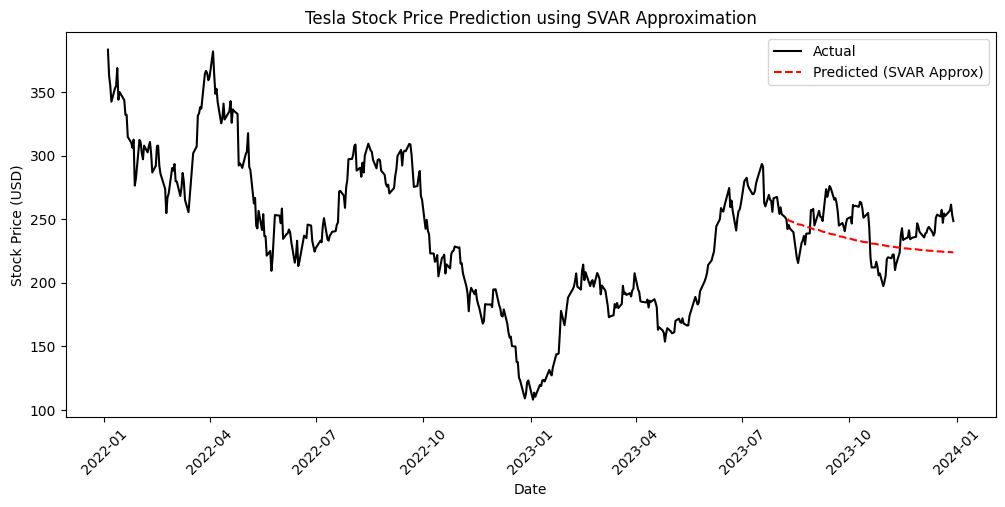

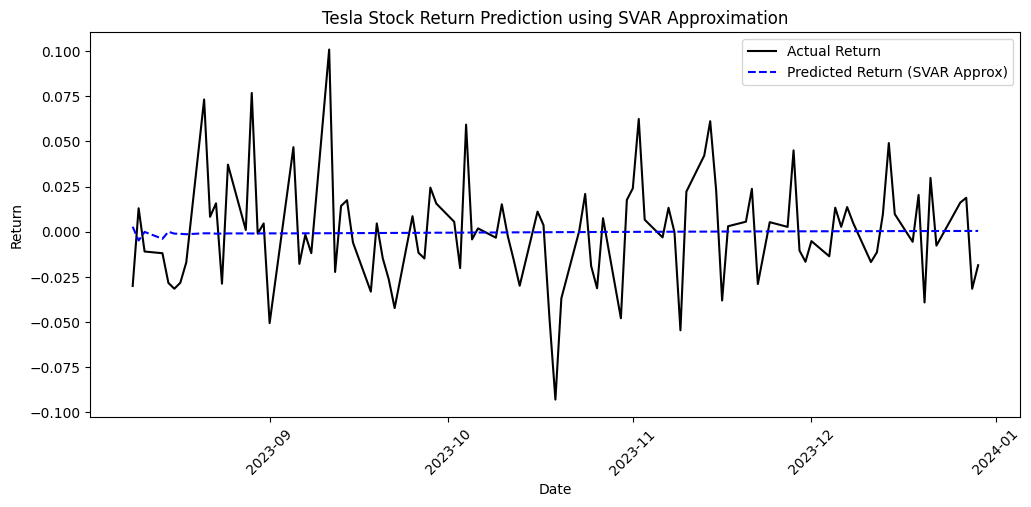

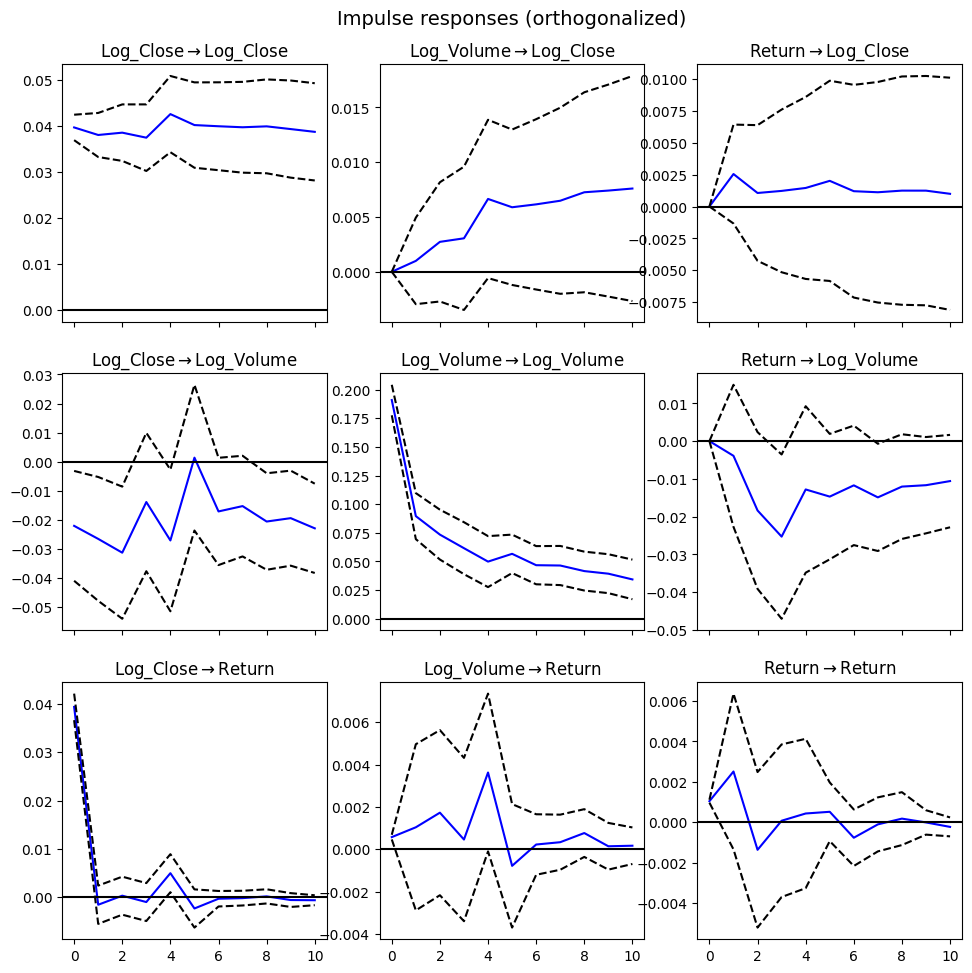

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error

# ✅ 1️⃣ 테슬라(TSLA) 주가 데이터 다운로드 (최근 2년치)
df = yf.download("TSLA", start="2022-01-01", end="2024-01-01")

# ✅ 2️⃣ 데이터 전처리 및 Feature 생성
df = df.reset_index()
df["Date"] = pd.to_datetime(df["Date"])  # 날짜 변환
df["Return"] = df["Close"].pct_change()  # 수익률 계산
df["Log_Close"] = np.log(df["Close"].replace(0, np.nan))  # 로그 변환 종가
df["Log_Volume"] = np.log(df["Volume"].replace(0, np.nan))  # 로그 변환 거래량
df = df.dropna().reset_index(drop=True)  # 결측값 제거 및 인덱스 리셋

# ✅ 3️⃣ 변수 선택 (SVAR 모델 입력 변수)
data = df[["Date", "Log_Close", "Log_Volume", "Return"]].set_index("Date")

# ✅ 4️⃣ 학습 및 테스트 데이터 분할 (80% 학습, 20% 테스트)
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size].copy(), data.iloc[train_size:].copy()

# ✅ 4️⃣-1 결측치 및 무한대 값 제거
train = train.dropna()
train = train[~train.isin([np.inf, -np.inf]).any(axis=1)]
test = test.dropna()
test = test[~test.isin([np.inf, -np.inf]).any(axis=1)]

# ✅ 5️⃣ 최적의 VAR 차수(p) 선택 (AIC 기준)
lag_selection = VAR(train)
lag_results = lag_selection.select_order(maxlags=10)
best_lag = lag_results.aic  # AIC 최소값을 갖는 차수 선택
best_lag = max(best_lag, 1)  # ✅ 최소 1 이상 유지
print(f"✅ 최적의 차수 (p): {best_lag}")

# ✅ 6️⃣ VAR 모델 학습
var_model = VAR(train)
var_fit = var_model.fit(best_lag)

# ✅ 7️⃣ Cholesky 분해를 사용한 구조적 SVAR 근사
cov_matrix = var_fit.sigma_u  # 잔차 공분산 행렬
chol_decomp = np.linalg.cholesky(cov_matrix)  # Cholesky 분해 적용

# ✅ 8️⃣ 예측 수행 (테스트 데이터 크기만큼 예측)
test_pred = var_fit.forecast(train.values[-best_lag:], steps=len(test))

# ✅ 9️⃣ 예측된 결과를 데이터프레임으로 변환
test_pred_df = pd.DataFrame(test_pred, index=test.index, columns=["Log_Close_Pred", "Log_Volume_Pred", "Return_Pred"])

# ✅ 🔟 로그 변환 해제
test_pred_df["Close_Pred"] = np.exp(test_pred_df["Log_Close_Pred"])

# ✅ 11️⃣ 성능 평가 (MSE)
test_mse = mean_squared_error(np.exp(test["Log_Close"]), test_pred_df["Close_Pred"])
print(f"📌 Test MSE: {test_mse:.4f}")

# ✅ 12️⃣ 결과 시각화 (실제 vs 예측 종가)
plt.figure(figsize=(12, 5))
plt.plot(df["Date"], df["Close"], label="Actual", color="black")
plt.plot(test_pred_df.index, test_pred_df["Close_Pred"], label="Predicted (SVAR Approx)", linestyle="--", color="red")
plt.title("Tesla Stock Price Prediction using SVAR Approximation")
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.xticks(rotation=45)
plt.legend()
plt.show()

# ✅ 13️⃣ 수익률 예측 시각화
plt.figure(figsize=(12, 5))
plt.plot(test_pred_df.index, test["Return"], label="Actual Return", color="black")
plt.plot(test_pred_df.index, test_pred_df["Return_Pred"], label="Predicted Return (SVAR Approx)", linestyle="--", color="blue")
plt.title("Tesla Stock Return Prediction using SVAR Approximation")
plt.xlabel("Date")
plt.ylabel("Return")
plt.xticks(rotation=45)
plt.legend()
plt.show()

# ✅ 12️⃣ Impulse Response Function (IRF) 분석 (Cholesky 기반)
irf = var_fit.irf(10)  # 10-step Impulse Response Function
irf.plot(orth=True)
plt.show()



[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


✅ 최적의 차수 (p): 5
⚠️ Warning: ValueError during model fitting at step 0: zero-size array to reduction operation maximum which has no identity
⚠️ Warning: ValueError during model fitting at step 1: zero-size array to reduction operation maximum which has no identity
⚠️ Warning: ValueError during model fitting at step 2: zero-size array to reduction operation maximum which has no identity
⚠️ Warning: ValueError during model fitting at step 3: zero-size array to reduction operation maximum which has no identity
⚠️ Warning: ValueError during model fitting at step 4: zero-size array to reduction operation maximum which has no identity
⚠️ Warning: ValueError during model fitting at step 5: zero-size array to reduction operation maximum which has no identity
⚠️ Warning: ValueError during model fitting at step 6: zero-size array to reduction operation maximum which has no identity
⚠️ Warning: ValueError during model fitting at step 7: zero-size array to reduction operation maximum which has no i

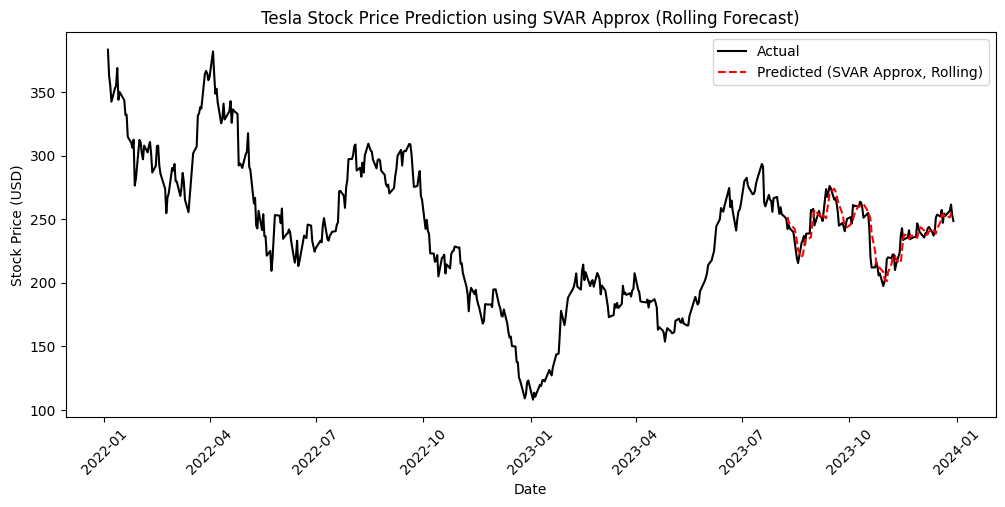

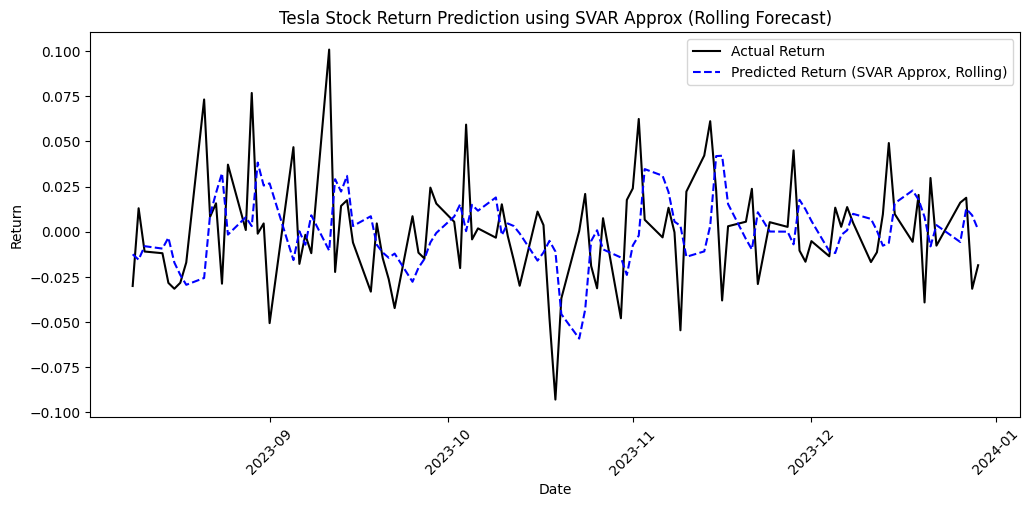

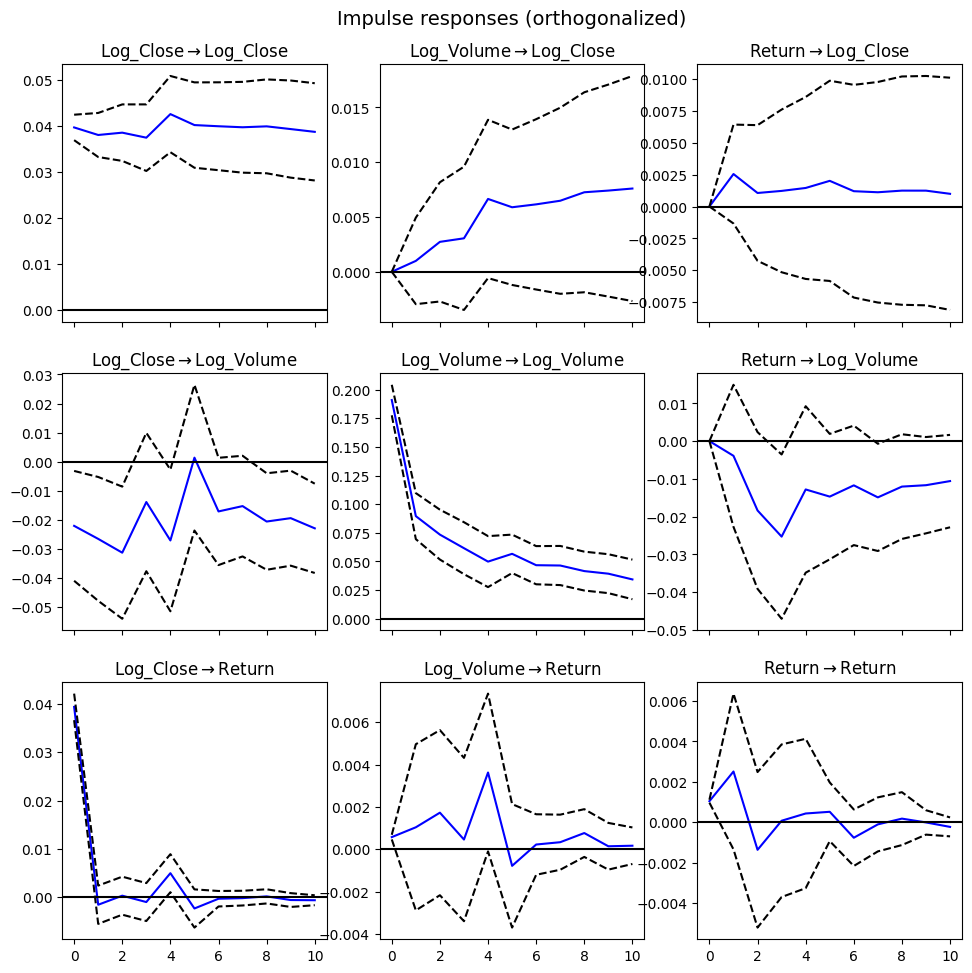

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error

# ✅ 1️⃣ 테슬라(TSLA) 주가 데이터 다운로드 (최근 2년치)
df = yf.download("TSLA", start="2022-01-01", end="2024-01-01")

# ✅ 2️⃣ 데이터 전처리 및 Feature 생성
df = df.reset_index()
df["Date"] = pd.to_datetime(df["Date"])  # 날짜 변환
df["Return"] = df["Close"].pct_change()  # 수익률 계산
df["Log_Close"] = np.log(df["Close"].replace(0, np.nan))  # 로그 변환 종가
df["Log_Volume"] = np.log(df["Volume"].replace(0, np.nan))  # 로그 변환 거래량
df = df.dropna().reset_index(drop=True)  # 결측값 제거 및 인덱스 리셋

# ✅ 3️⃣ 변수 선택 (SVAR 모델 입력 변수)
data = df[["Date", "Log_Close", "Log_Volume", "Return"]].set_index("Date")

# ✅ 4️⃣ 학습 및 테스트 데이터 분할 (80% 학습, 20% 테스트)
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size].copy(), data.iloc[train_size:].copy()

# ✅ 4️⃣-1 결측치 및 무한대 값 제거
train = train.dropna()
train = train[~train.isin([np.inf, -np.inf]).any(axis=1)]
test = test.dropna()
test = test[~test.isin([np.inf, -np.inf]).any(axis=1)]

# ✅ 5️⃣ 최적의 VAR 차수(p) 선택 (AIC 기준)
lag_selection = VAR(train)
lag_results = lag_selection.select_order(maxlags=10)
best_lag = lag_results.aic  # AIC 최소값을 갖는 차수 선택
best_lag = max(best_lag, 1)  # ✅ 최소 1 이상 유지
print(f"✅ 최적의 차수 (p): {best_lag}")

# ✅ 6️⃣ SVAR을 위한 Cholesky 분해 (구조적 제약 적용)
var_model = VAR(train)
var_fit = var_model.fit(best_lag)

cov_matrix = var_fit.sigma_u  # 잔차 공분산 행렬
chol_decomp = np.linalg.cholesky(cov_matrix)  # Cholesky 분해 적용

# ✅ 7️⃣ 롤링 SVAR 예측 (One-step Rolling Forecast)
rolling_predictions = []
history = train.values.tolist()  # Use the entire train data as initial history

for t in range(len(test)):
    # Create history_df from the last 'best_lag' data points in history
    history_df = pd.DataFrame(history[-best_lag:], columns=train.columns)

    # ✅ 데이터 문제 감지 및 해결
    if len(history_df) < best_lag or history_df.empty or history_df.nunique().min() <= 1:
        print(f"⚠️ Warning: Insufficient or constant data at step {t}. Adjusting...")

        # 최근 3일치 평균으로 대체
        avg_values = np.mean(history[-3:], axis=0).tolist() if len(history) >= 3 else history[-1]
        rolling_predictions.append(avg_values)  # 최근 평균값 사용

        # 실제 데이터를 추가하여 업데이트
        history.append(test.iloc[t].values.tolist())
        continue  # Skip to the next iteration

    # ✅ 6️⃣-4 모델 학습 및 예측
    model = VAR(history_df)

    # 데이터가 모두 동일한 경우 모델 학습 방지
    if np.all(history_df.values == history_df.values[0, :], axis=0).any():
        print(f"⚠️ Warning: No variation in data at step {t}. Adjusting...")
        avg_values = np.mean(history[-3:], axis=0).tolist()
        rolling_predictions.append(avg_values)
        history.append(test.iloc[t].values.tolist())
        continue

    try:
        model_fit = model.fit(best_lag)
    except ValueError as e:
        print(f"⚠️ Warning: ValueError during model fitting at step {t}: {e}")
        avg_values = np.mean(history[-3:], axis=0).tolist()
        rolling_predictions.append(avg_values)
        history.append(test.iloc[t].values.tolist())
        continue

    # ✅ 6️⃣-5 한 스텝 예측 수행 (SVAR 적용)
    pred = model_fit.forecast(history_df.values[-best_lag:], steps=1)
    svar_pred = np.dot(chol_decomp, pred.T).T  # Cholesky 변환 적용
    rolling_predictions.append(svar_pred[0])

    # ✅ 6️⃣-6 예측값을 history에 추가하여 업데이트
    history.append(svar_pred[0].tolist())  # 예측값 추가

# ✅ 7️⃣ 예측된 결과를 데이터프레임으로 변환
rolling_predictions = np.array(rolling_predictions)
test_pred_df = pd.DataFrame(rolling_predictions, index=test.index[:len(rolling_predictions)], columns=["Log_Close_Pred", "Log_Volume_Pred", "Return_Pred"])

# ✅ 8️⃣ 로그 변환 해제
test_pred_df["Close_Pred"] = np.exp(test_pred_df["Log_Close_Pred"])

# ✅ 9️⃣ 성능 평가 (MSE)
test_mse = mean_squared_error(np.exp(test["Log_Close"][:len(test_pred_df)]), test_pred_df["Close_Pred"])
print(f"📌 Test MSE: {test_mse:.4f}")

# ✅ 10️⃣ 결과 시각화 (실제 vs 예측 종가)
plt.figure(figsize=(12, 5))
plt.plot(df["Date"], df["Close"], label="Actual", color="black")
plt.plot(test_pred_df.index, test_pred_df["Close_Pred"], label="Predicted (SVAR Approx, Rolling)", linestyle="--", color="red")
plt.title("Tesla Stock Price Prediction using SVAR Approx (Rolling Forecast)")
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.xticks(rotation=45)
plt.legend()
plt.show()

# ✅ 11️⃣ 수익률 예측 시각화
plt.figure(figsize=(12, 5))
plt.plot(test_pred_df.index, test["Return"][:len(test_pred_df)], label="Actual Return", color="black")
plt.plot(test_pred_df.index, test_pred_df["Return_Pred"], label="Predicted Return (SVAR Approx, Rolling)", linestyle="--", color="blue")
plt.title("Tesla Stock Return Prediction using SVAR Approx (Rolling Forecast)")
plt.xlabel("Date")
plt.ylabel("Return")
plt.xticks(rotation=45)
plt.legend()
plt.show()

# ✅ 12️⃣ Impulse Response Function (IRF) 분석 (Cholesky 기반)
irf = var_fit.irf(10)  # 10-step Impulse Response Function
irf.plot(orth=True)
plt.show()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


TSLA/SPY: 500 returns | 2022-01-04 ~ 2023-12-29
train=400, test=100
alignment check → p0_test=P[400] vs actual_test_price starts at P[401] (len=100)
[Full] lag=1, A(recursive) used.


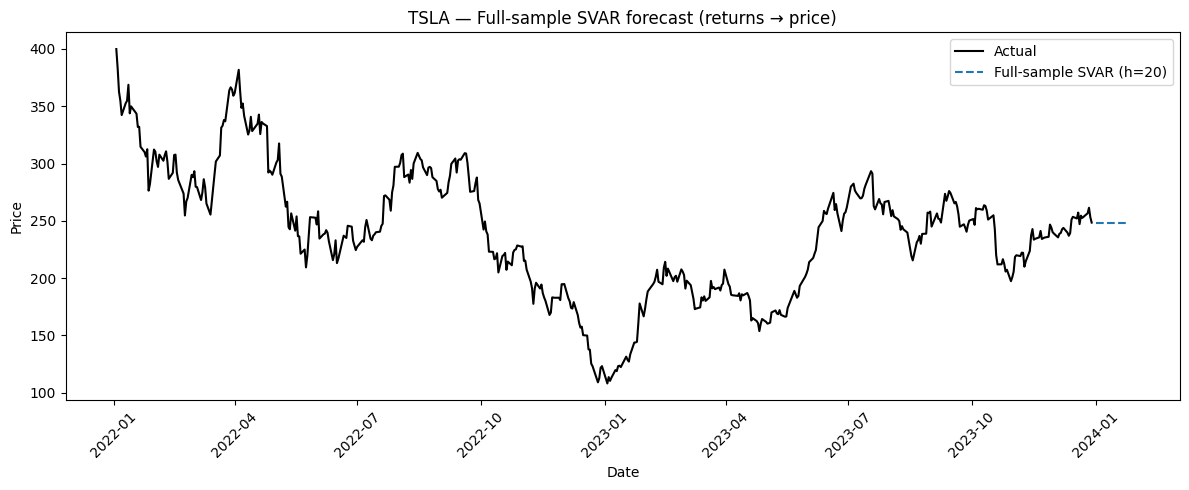

[Fixed-origin] lag=1, A(recursive) used.
[Fixed-origin] RMSE=19.2942 | MAE=14.8699 | R2=-0.2166


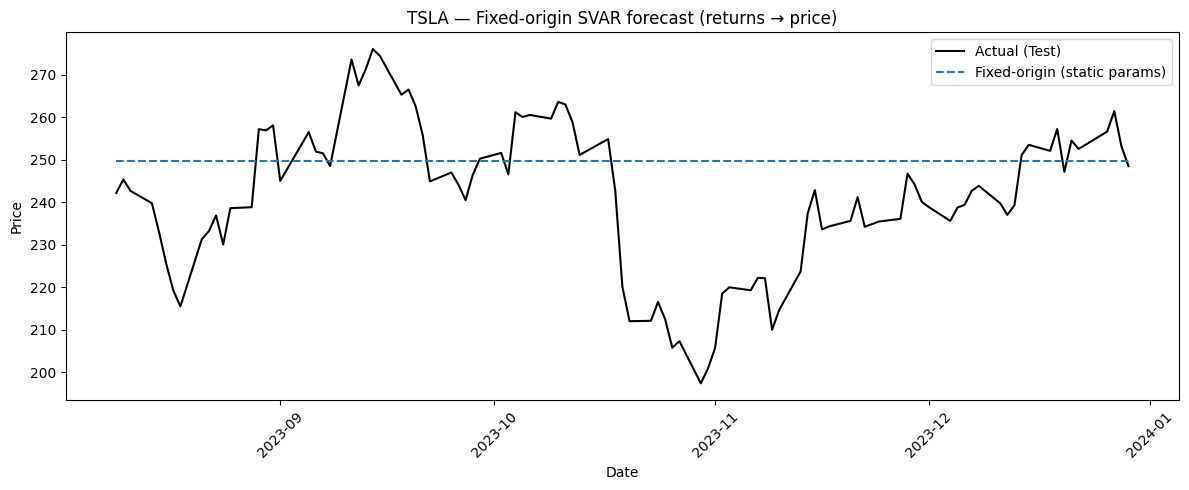

[Rolling window] RMSE=19.2942 | MAE=14.8699 | R2=-0.2166


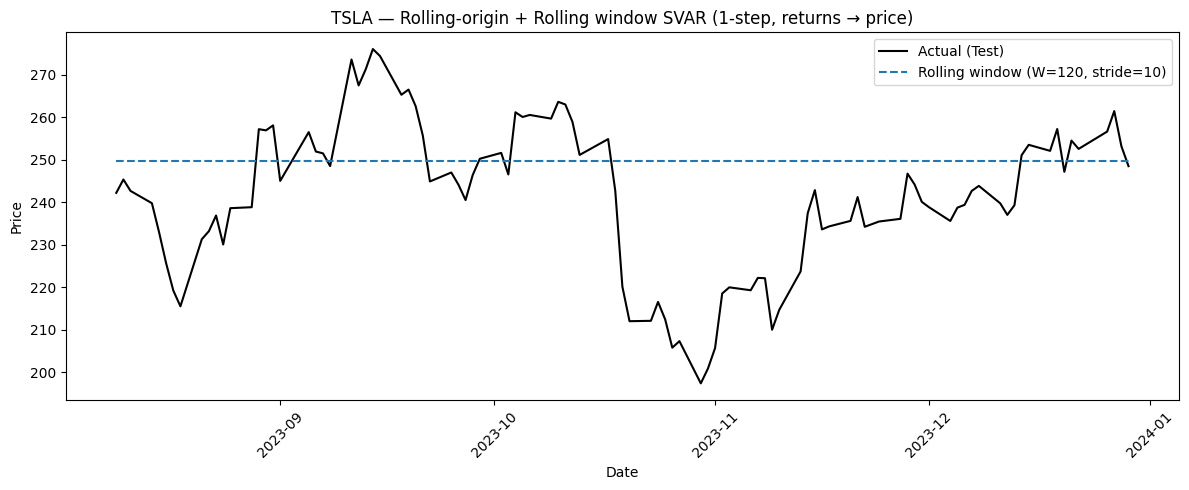

[Expanding window] RMSE=19.2942 | MAE=14.8699 | R2=-0.2166

=== Summary on Test (TSLA price) ===
                    Method      RMSE       MAE        R2
              Fixed-origin 19.294178 14.869899 -0.216602
Rolling (W=120, stride=10) 19.294178 14.869899 -0.216602
     Expanding (stride=10) 19.294178 14.869899 -0.216602


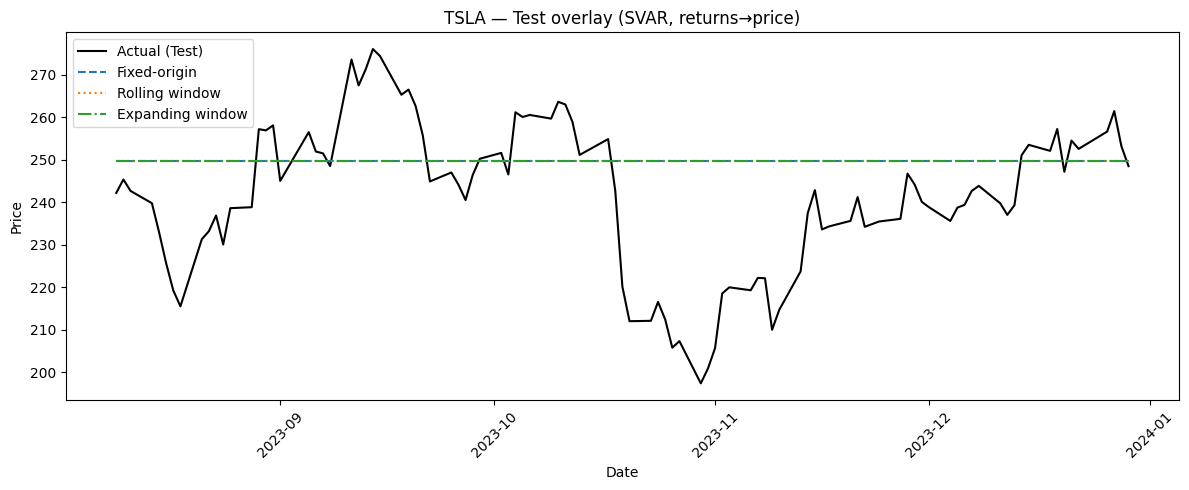

In [2]:
# =========================================================
# Colab 준비 (필요할 때만 실행)
# =========================================================
# %pip -q install yfinance statsmodels scikit-learn

import warnings
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.svar_model import SVAR
from statsmodels.tools.sm_exceptions import ConvergenceWarning
try:
    from statsmodels.tsa.base.tsa_model import ValueWarning
except Exception:
    class ValueWarning(Warning): pass

# ---- 경고 억제 ----
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=ValueWarning)
warnings.filterwarnings("ignore", category=UserWarning)

plt.rcParams["figure.figsize"] = (12, 5)

# =========================================================
# 1) 데이터 로드 (TSLA, SPY) & 로그수익률
# =========================================================
symbol_y = "TSLA"
symbol_x = "SPY"
start_date = "2022-01-01"
end_date   = "2024-01-01"

px_y = yf.download(symbol_y, start=start_date, end=end_date, auto_adjust=True)[["Close"]]
px_x = yf.download(symbol_x, start=start_date, end=end_date, auto_adjust=True)[["Close"]]

# 공통 날짜로 inner join
px = px_y.join(px_x, how="inner", lsuffix=f"_{symbol_y}", rsuffix=f"_{symbol_x}").dropna()
px.columns = [f"Close_{symbol_y}", f"Close_{symbol_x}"]
px.index = pd.to_datetime(px.index)

# 로그수익률(%)—정상성 위해 레벨 대신 수익률 사용
ret = np.log(px).diff().dropna() * 100.0
ret.columns = [f"ret_{symbol_y}", f"ret_{symbol_x}"]

dates = ret.index
print(f"{symbol_y}/{symbol_x}: {len(ret)} returns | {dates[0].date()} ~ {dates[-1].date()}")

# =========================================================
# 2) 학습/테스트 분할 (⚠️ returns 기준으로 split)
# =========================================================
train_size = int(len(ret) * 0.8)
ret_train, ret_test = ret.iloc[:train_size].copy(), ret.iloc[train_size:].copy()
dates_train, dates_test = dates[:train_size], dates[train_size:]

# ✅ 가격 벡터와 정렬 규칙 (returns 길이 = prices 길이 - 1)
price_y = px[f"Close_{symbol_y}"]

s = train_size
p0_test = float(price_y.iloc[s])            # ✅ 테스트 시작 “기준가격” = P[s]
actual_test_price = price_y.iloc[s+1:].to_numpy()  # ✅ 실제 테스트 가격 = P[s+1:] (len == len(ret_test))
dates_test_price  = price_y.index[s+1:]            # 동일한 날짜 인덱스

print(f"train={len(ret_train)}, test={len(ret_test)}")
print(f"alignment check → p0_test=P[{s}] vs actual_test_price starts at P[{s+1}] (len={len(actual_test_price)})")

# =========================================================
# 3) 유틸 함수
# =========================================================
def rmse(a, b): return float(np.sqrt(mean_squared_error(a, b)))
def mae(a, b):  return float(np.mean(np.abs(np.asarray(a) - np.asarray(b))))
def r2(a, b):   return float(r2_score(a, b))

def to_price_path(p0, returns_pct):
    """시작가격 p0와 수익률(%)을 받아 가격 경로 복원"""
    p0 = float(p0)
    out = np.empty(len(returns_pct), dtype=float)
    prev = p0
    for i, r in enumerate(np.asarray(returns_pct, dtype=float)):
        prev = prev * np.exp(r / 100.0)
        out[i] = prev
    return out

def select_var_lag(y_df, maxlags=10, ic="aic"):
    """VAR의 lag 차수 선택(AIC/BIC). 실패 시 1 반환."""
    try:
        sel = VAR(y_df).select_order(maxlags=maxlags)
        lag = getattr(sel, ic)
        return int(lag if lag and np.isfinite(lag) else 1)
    except Exception:
        return 1

def make_recursive_A(k):
    """재귀식(Cholesky) 식별을 위한 A행렬: diag=1, 상삼각=0, 하삼각=NaN(추정)"""
    A = np.eye(k)
    for i in range(k):
        for j in range(i+1, k):
            A[i, j] = 0.0
    for i in range(1, k):
        for j in range(0, i):
            A[i, j] = np.nan
    return A

def fit_svar_safe(y_df, lags, A):
    """
    SVAR 안전 적합. statsmodels 버전에 따라 fit 인자가 다를 수 있어 두 방식 시도.
    실패 시 None.
    """
    try:
        model = SVAR(y_df, svar_type="A", A=A)
        try:
            res = model.fit(lags)            # (가능한 버전)
        except TypeError:
            res = model.fit(maxlags=lags)    # (대안)
        return res
    except Exception:
        return None

def forecast_one_step(res, y_hist_df):
    """
    1-step ahead 예측 (k차원 벡터).
    실패 시 naive(0% 수익률).
    """
    try:
        k_ar = getattr(res, "k_ar", None)
        if k_ar is None:
            f = res.forecast(steps=1)  # 일부 버전
            return np.asarray(f)[0]
        y0 = np.asarray(y_hist_df)[-k_ar:, :]
        f = res.forecast(y0, steps=1)  # 일반적 VAR/SVAR API
        return np.asarray(f)[0]
    except Exception:
        return np.zeros(y_hist_df.shape[1], dtype=float)

# =========================================================
# 4) 하이퍼파라미터
# =========================================================
MAX_LAG = 10     # VAR 차수 최대 탐색
W       = 120    # Rolling 창 길이
stride  = 10     # Rolling/Expanding에서 매 stride마다 차수 재선택
h       = 20     # Full-sample 미래 예측 스텝(평가용 X)

# =========================================================
# A) Full-sample (final fit) — 전체 표본으로 적합 → 미래 h 예측
# =========================================================
lag_full = select_var_lag(ret, maxlags=MAX_LAG, ic="aic")
A_full   = make_recursive_A(k=ret.shape[1])
fit_full = fit_svar_safe(ret, lag_full, A_full)
print(f"[Full] lag={lag_full}, A(recursive) used.")

fcst_full = (fit_full.forecast(steps=h).astype(float)
             if fit_full is not None else np.zeros((h, ret.shape[1])))
future_dates = pd.bdate_range(dates[-1] + pd.Timedelta(days=1), periods=h)

# TSLA 가격 경로 예시 시각화
px_full = to_price_path(price_y.iloc[-1], fcst_full[:, 0])
plt.figure()
plt.plot(price_y.index, price_y.values, label="Actual", color="black")
plt.plot(future_dates, px_full, label=f"Full-sample SVAR (h={h})", linestyle="--")
plt.title(f"{symbol_y} — Full-sample SVAR forecast (returns → price)")
plt.xlabel("Date"); plt.ylabel("Price"); plt.xticks(rotation=45); plt.legend(); plt.tight_layout(); plt.show()

# =========================================================
# B) Fixed-origin (holdout) — 80% 학습 한 번 적합 → 테스트 전구간 예측
# =========================================================
lag_fix = select_var_lag(ret_train, maxlags=MAX_LAG, ic="aic")
A_fix   = make_recursive_A(k=ret_train.shape[1])
fit_fix = fit_svar_safe(ret_train, lag_fix, A_fix)
print(f"[Fixed-origin] lag={lag_fix}, A(recursive) used.")

pred_fix_ret = (fit_fix.forecast(steps=len(ret_test)).astype(float)
                if fit_fix is not None else np.zeros((len(ret_test), ret.shape[1])))

# ✅ 수익률→가격 복원(테스트 시작점 p0_test = P[s])
pred_fix_price = to_price_path(p0_test, pred_fix_ret[:, 0])

# ✅ 지표(가격 기준, 길이/날짜 정렬 OK)
rmse_fix = rmse(actual_test_price, pred_fix_price)
mae_fix  = mae(actual_test_price, pred_fix_price)
r2_fix   = r2 (actual_test_price, pred_fix_price)
print(f"[Fixed-origin] RMSE={rmse_fix:.4f} | MAE={mae_fix:.4f} | R2={r2_fix:.4f}")

plt.figure()
plt.plot(dates_test_price, actual_test_price, label="Actual (Test)", color="black")
plt.plot(dates_test_price, pred_fix_price,   label="Fixed-origin (static params)", linestyle="--")
plt.title(f"{symbol_y} — Fixed-origin SVAR forecast (returns → price)")
plt.xlabel("Date"); plt.ylabel("Price"); plt.xticks(rotation=45); plt.legend(); plt.tight_layout(); plt.show()

# =========================================================
# C) Rolling-origin + Rolling window — 고정 길이 W, 매 스텝 재적합
# =========================================================
hist = ret_train.copy()
pred_roll_ret = np.full((len(ret_test), ret.shape[1]), np.nan, dtype=float)

lag_curr = select_var_lag(hist.tail(W) if len(hist) > W else hist, maxlags=MAX_LAG, ic="aic")

for i in range(len(ret_test)):
    y_win = hist.tail(W) if len(hist) > W else hist
    if stride and (i % stride == 0):
        lag_curr = select_var_lag(y_win, maxlags=MAX_LAG, ic="aic")
    A_curr   = make_recursive_A(k=y_win.shape[1])
    fit_curr = fit_svar_safe(y_win, lag_curr, A_curr)
    pred_vec = forecast_one_step(fit_curr, y_win) if fit_curr is not None else np.zeros(y_win.shape[1])
    pred_roll_ret[i, :] = pred_vec
    # 워크-포워드(실제값 주입)
    hist = pd.concat([hist, ret_test.iloc[[i]]], axis=0)

pred_roll_price = to_price_path(p0_test, pred_roll_ret[:, 0])

rmse_r = rmse(actual_test_price, pred_roll_price)
mae_r  = mae(actual_test_price, pred_roll_price)
r2_r   = r2 (actual_test_price, pred_roll_price)
print(f"[Rolling window] RMSE={rmse_r:.4f} | MAE={mae_r:.4f} | R2={r2_r:.4f}")

plt.figure()
plt.plot(dates_test_price, actual_test_price, label="Actual (Test)", color="black")
plt.plot(dates_test_price, pred_roll_price,   label=f"Rolling window (W={W}, stride={stride})", linestyle="--")
plt.title(f"{symbol_y} — Rolling-origin + Rolling window SVAR (1-step, returns → price)")
plt.xlabel("Date"); plt.ylabel("Price"); plt.xticks(rotation=45); plt.legend(); plt.tight_layout(); plt.show()

# =========================================================
# D) Rolling-origin + Expanding window — 누적 창, 매 스텝 재적합
# =========================================================
hist = ret_train.copy()
pred_exp_ret = np.full((len(ret_test), ret.shape[1]), np.nan, dtype=float)

lag_curr = select_var_lag(hist, maxlags=MAX_LAG, ic="aic")

for i in range(len(ret_test)):
    if stride and (i % stride == 0):
        lag_curr = select_var_lag(hist, maxlags=MAX_LAG, ic="aic")
    A_curr   = make_recursive_A(k=hist.shape[1])
    fit_curr = fit_svar_safe(hist, lag_curr, A_curr)
    pred_vec = forecast_one_step(fit_curr, hist) if fit_curr is not None else np.zeros(hist.shape[1])
    pred_exp_ret[i, :] = pred_vec
    hist = pd.concat([hist, ret_test.iloc[[i]]], axis=0)

pred_exp_price = to_price_path(p0_test, pred_exp_ret[:, 0])

rmse_e = rmse(actual_test_price, pred_exp_price)
mae_e  = mae(actual_test_price, pred_exp_price)
r2_e   = r2 (actual_test_price, pred_exp_price)
print(f"[Expanding window] RMSE={rmse_e:.4f} | MAE={mae_e:.4f} | R2={r2_e:.4f}")

# =========================================================
# 9) 요약 & 오버레이
# =========================================================
summary = pd.DataFrame({
    "Method": ["Fixed-origin", f"Rolling (W={W}, stride={stride})", f"Expanding (stride={stride})"],
    "RMSE":   [rmse_fix, rmse_r, rmse_e],
    "MAE":    [mae_fix,  mae_r,  mae_e],
    "R2":     [r2_fix,   r2_r,   r2_e],
})
print("\n=== Summary on Test (TSLA price) ===")
print(summary.sort_values("RMSE").to_string(index=False))

plt.figure()
plt.plot(dates_test_price, actual_test_price, label="Actual (Test)", color="black", linewidth=1.5)
plt.plot(dates_test_price, pred_fix_price,  label="Fixed-origin", linestyle="--")
plt.plot(dates_test_price, pred_roll_price, label="Rolling window", linestyle=":")
plt.plot(dates_test_price, pred_exp_price,  label="Expanding window", linestyle="-.")
plt.title(f"{symbol_y} — Test overlay (SVAR, returns→price)")
plt.xlabel("Date"); plt.ylabel("Price"); plt.xticks(rotation=45); plt.legend(); plt.tight_layout(); plt.show()


[Full] lag=1, model used=VAR


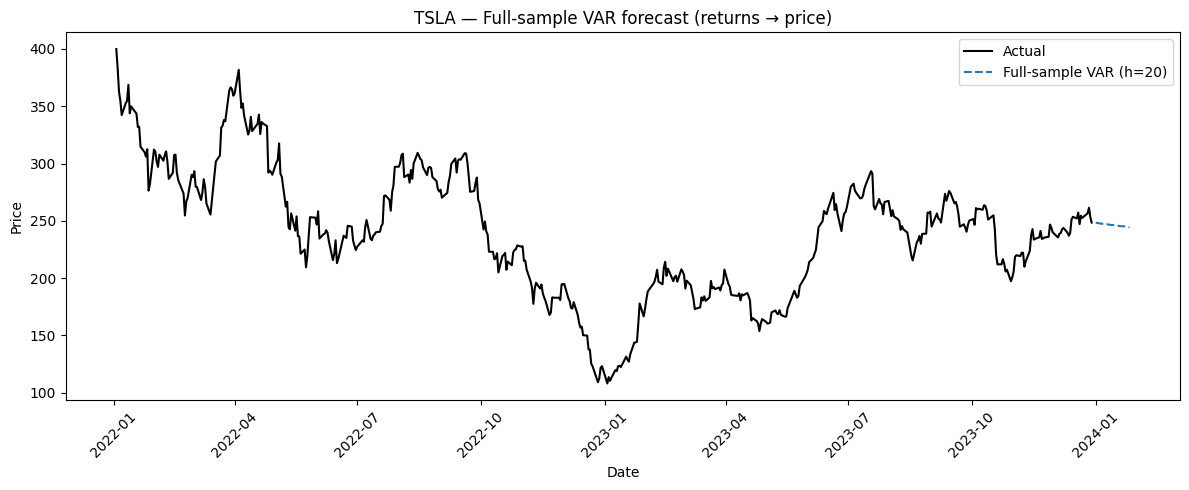

[Fixed-origin] lag=1, model used=VAR
[Fixed-origin] RMSE=18.8608 | MAE=16.4195 | R2=-0.1626


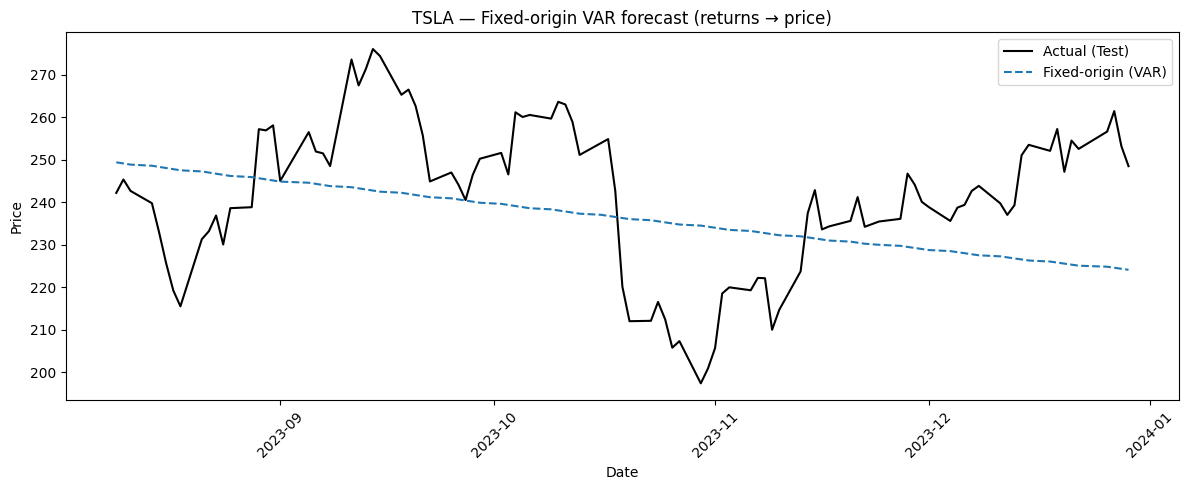

[Rolling] model used counts: {'SVAR': 0, 'VAR': 100, 'NONE': 0}
[Rolling window] RMSE=43.4523 | MAE=35.2736 | R2=-5.1705


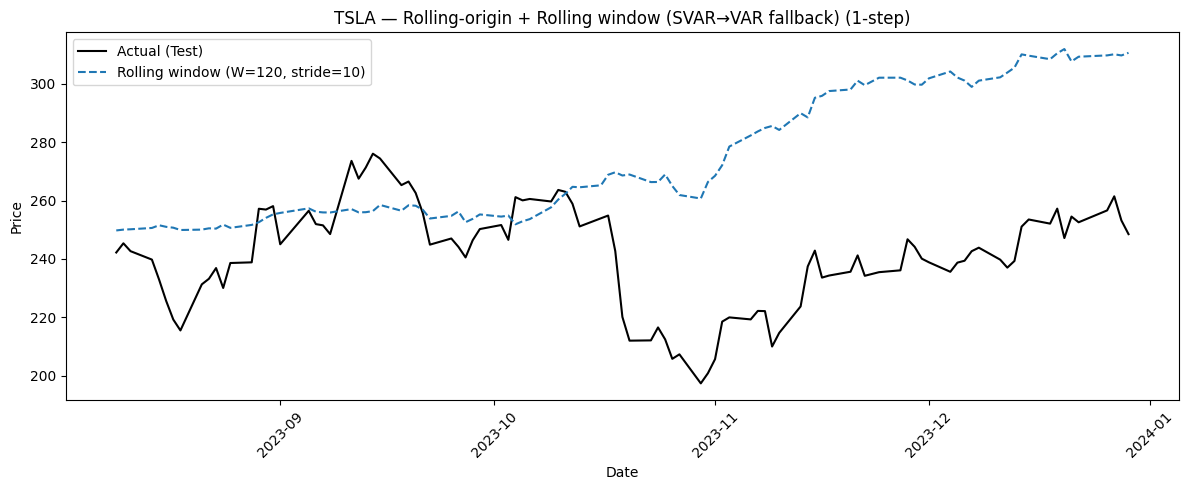

[Expanding] model used counts: {'SVAR': 0, 'VAR': 100, 'NONE': 0}
[Expanding window] RMSE=18.9611 | MAE=16.5299 | R2=-0.1750

=== Summary on Test (TSLA price) ===
                    Method      RMSE       MAE        R2
              Fixed-origin 18.860773 16.419458 -0.162558
     Expanding (stride=10) 18.961139 16.529893 -0.174964
Rolling (W=120, stride=10) 43.452290 35.273626 -5.170512


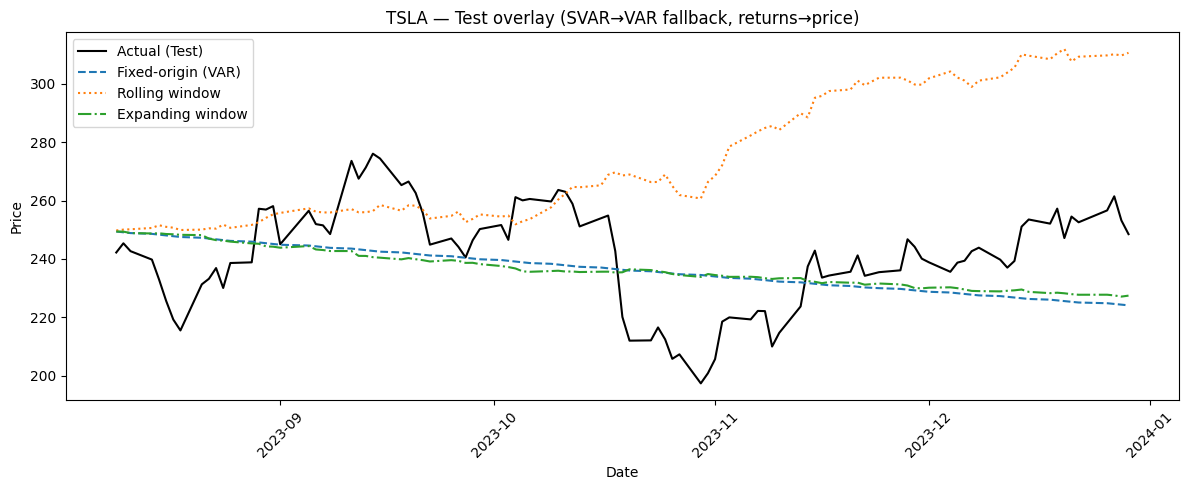


All-equal checks: fix==roll: False | fix==exp: False


In [7]:
# =========================================================
# 4) 하이퍼파라미터 (약간 보수적으로)
# =========================================================
MAX_LAG = 5      # 창이 짧을 때 과적합/수렴 실패 줄이기 위해 살짝 낮춤
W       = 120    # Rolling 창 길이
stride  = 10     # Rolling/Expanding에서 매 stride마다 차수 재선택
h       = 20     # Full-sample 미래 예측 스텝(평가용 X)

# =========================================================
# SVAR 실패 시 VAR로 자동 폴백 + 1-step/멀티스텝 통합 예측 함수
# =========================================================
from statsmodels.tsa.api import VAR

def fit_var_safe(y_df, lags):
    try:
        return VAR(y_df).fit(lags)
    except Exception:
        return None

def fit_svar_safe(y_df, lags, A):
    """(이전 셀에 있다면 생략해도 OK) SVAR 안전 적합."""
    try:
        model = SVAR(y_df, svar_type="A", A=A)
        try:
            return model.fit(lags)
        except TypeError:
            return model.fit(maxlags=lags)
    except Exception:
        return None

def fit_svar_or_var(y_df, lags, A):
    """우선 SVAR, 실패 시 VAR, 둘 다 실패면 NONE."""
    res_s = fit_svar_safe(y_df, lags, A)
    if res_s is not None and np.isfinite(getattr(res_s, "llf", 0.0)):
        return "SVAR", res_s
    res_v = fit_var_safe(y_df, lags)
    if res_v is not None and np.isfinite(getattr(res_v, "llf", 0.0)):
        return "VAR", res_v
    return "NONE", None

def forecast_one_step_any(res, y_hist_df):
    """SVAR/VAR 1-step 공용. 실패 시 0% 수익률(naive)."""
    try:
        if hasattr(res, "k_ar"):               # VARResults
            y0 = np.asarray(y_hist_df)[-res.k_ar:, :]
            f  = res.forecast(y0, steps=1)
        else:                                   # 일부 SVARResults
            f  = res.forecast(steps=1)
        return np.asarray(f)[0]
    except Exception:
        return np.zeros(y_hist_df.shape[1], dtype=float)

def forecast_multi_any(res, y_hist_df, steps):
    """
    SVAR/VAR 공통 멀티스텝(h-step) 예측.
    - VAR: 마지막 k_ar개를 y 인자로 넣어 forecast(y, steps)
    - 일부 SVAR: forecast(steps)만으로 동작
    - 실패 시 1-step을 steps회 누적(roll-forward)로 폴백
    """
    if res is None or steps <= 0:
        return np.zeros((0, y_hist_df.shape[1]))
    try:
        if hasattr(res, "k_ar"):               # VARResults
            y0 = np.asarray(y_hist_df)[-res.k_ar:, :]
            fcst = res.forecast(y=y0, steps=steps)
        else:                                   # SVARResults 대응
            fcst = res.forecast(steps=steps)
        return np.asarray(fcst, dtype=float)
    except Exception:
        hist = np.asarray(y_hist_df, dtype=float)
        out = np.empty((steps, hist.shape[1]), dtype=float)
        for i in range(steps):
            out[i, :] = forecast_one_step_any(res, hist)
            hist = np.vstack([hist, out[i, :]])
        return out

def make_recursive_A(k):
    """재귀(Cholesky) 식별 A행렬: diag=1, 상삼각=0, 하삼각=NaN(추정)."""
    A = np.eye(k)
    for i in range(k):
        for j in range(i+1, k):
            A[i, j] = 0.0
    for i in range(1, k):
        for j in range(0, i):
            A[i, j] = np.nan
    return A

def select_var_lag(y_df, maxlags=10, ic="aic"):
    """VAR lag 차수 선택(AIC/BIC). 실패 시 1."""
    try:
        sel = VAR(y_df).select_order(maxlags=maxlags)
        lag = getattr(sel, ic)
        return int(lag if lag and np.isfinite(lag) else 1)
    except Exception:
        return 1

def to_price_path(p0, returns_pct):
    """시작가격 p0와 수익률(%)로 가격 경로 복원."""
    p0 = float(p0)
    out = np.empty(len(returns_pct), dtype=float)
    prev = p0
    for i, r in enumerate(np.asarray(returns_pct, dtype=float)):
        prev = prev * np.exp(r / 100.0)
        out[i] = prev
    return out

def rmse(a, b): return float(np.sqrt(mean_squared_error(a, b)))
def mae(a, b):  return float(np.mean(np.abs(np.asarray(a) - np.asarray(b))))
def r2(a, b):   return float(r2_score(a, b))

# =========================================================
# A) Full-sample (final fit) — 전체 표본으로 적합 → 미래 h 예측
# =========================================================
lag_full = select_var_lag(ret, maxlags=MAX_LAG, ic="aic")
A_full   = make_recursive_A(k=ret.shape[1])
m_full, fit_full = fit_svar_or_var(ret, lag_full, A_full)
print(f"[Full] lag={lag_full}, model used={m_full}")

fcst_full = (forecast_multi_any(fit_full, ret, h)
             if m_full != "NONE" else np.zeros((h, ret.shape[1])))
future_dates = pd.bdate_range(ret.index[-1] + pd.Timedelta(days=1), periods=h)

# TSLA 가격 경로(예시)
price_y = px[f"Close_{symbol_y}"]  # 상위 셀에 이미 있음
px_full = to_price_path(price_y.iloc[-1], fcst_full[:, 0])

plt.figure()
plt.plot(price_y.index, price_y.values, label="Actual", color="black")
plt.plot(future_dates, px_full, label=f"Full-sample {m_full} (h={h})", linestyle="--")
plt.title(f"{symbol_y} — Full-sample {m_full} forecast (returns → price)")
plt.xlabel("Date"); plt.ylabel("Price"); plt.xticks(rotation=45); plt.legend(); plt.tight_layout(); plt.show()

# =========================================================
# B) Fixed-origin (holdout) — 80% 학습 한 번 적합 → 테스트 전구간 예측
#   * 실제 가격도 '학습 마지막 가격 + 실제 테스트 수익률 누적'으로 복원해 길이 일치
# =========================================================
lag_fix = select_var_lag(ret_train, maxlags=MAX_LAG, ic="aic")
A_fix   = make_recursive_A(k=ret_train.shape[1])
m_fix, fit_fix = fit_svar_or_var(ret_train, lag_fix, A_fix)
print(f"[Fixed-origin] lag={lag_fix}, model used={m_fix}")

pred_fix_ret = (forecast_multi_any(fit_fix, ret_train, len(ret_test))
                if m_fix != "NONE" else np.zeros((len(ret_test), ret.shape[1])))

# 수익률→가격 복원(테스트 시작점 기준)
p0_test = float(price_y.loc[ret_train.index[-1]])   # 학습 마지막 날짜의 가격
pred_fix_price    = to_price_path(p0_test, pred_fix_ret[:, 0])
actual_test_price = to_price_path(p0_test, ret_test.iloc[:, 0].to_numpy())  # 실제 수익률로 복원
dates_test_price  = ret_test.index

rmse_fix = rmse(actual_test_price, pred_fix_price)
mae_fix  = mae(actual_test_price, pred_fix_price)
r2_fix   = r2 (actual_test_price, pred_fix_price)
print(f"[Fixed-origin] RMSE={rmse_fix:.4f} | MAE={mae_fix:.4f} | R2={r2_fix:.4f}")

plt.figure()
plt.plot(dates_test_price, actual_test_price, label="Actual (Test)", color="black")
plt.plot(dates_test_price, pred_fix_price,   label=f"Fixed-origin ({m_fix})", linestyle="--")
plt.title(f"{symbol_y} — Fixed-origin {m_fix} forecast (returns → price)")
plt.xlabel("Date"); plt.ylabel("Price"); plt.xticks(rotation=45); plt.legend(); plt.tight_layout(); plt.show()

# =========================================================
# C) Rolling-origin + Rolling window — 고정 길이 W, 매 스텝 재적합
# =========================================================
hist = ret_train.copy()
pred_roll_ret = np.full((len(ret_test), ret.shape[1]), np.nan, dtype=float)
lag_curr = select_var_lag(hist.tail(W) if len(hist) > W else hist, maxlags=MAX_LAG, ic="aic")

used_counts_roll = {"SVAR":0, "VAR":0, "NONE":0}
for i in range(len(ret_test)):
    y_win = hist.tail(W) if len(hist) > W else hist
    if stride and (i % stride == 0):
        lag_curr = select_var_lag(y_win, maxlags=MAX_LAG, ic="aic")
    A_curr = make_recursive_A(k=y_win.shape[1])
    m_curr, fit_curr = fit_svar_or_var(y_win, lag_curr, A_curr)
    used_counts_roll[m_curr] += 1
    pred_vec = forecast_one_step_any(fit_curr, y_win) if m_curr != "NONE" else np.zeros(y_win.shape[1])
    pred_roll_ret[i, :] = pred_vec
    # 워크-포워드(실제값 주입)
    hist = pd.concat([hist, ret_test.iloc[[i]]], axis=0)

print("[Rolling] model used counts:", used_counts_roll)
pred_roll_price = to_price_path(p0_test, pred_roll_ret[:, 0])

rmse_r = rmse(actual_test_price, pred_roll_price)
mae_r  = mae(actual_test_price, pred_roll_price)
r2_r   = r2 (actual_test_price, pred_roll_price)
print(f"[Rolling window] RMSE={rmse_r:.4f} | MAE={mae_r:.4f} | R2={r2_r:.4f}")

plt.figure()
plt.plot(dates_test_price, actual_test_price, label="Actual (Test)", color="black")
plt.plot(dates_test_price, pred_roll_price,   label=f"Rolling window (W={W}, stride={stride})", linestyle="--")
plt.title(f"{symbol_y} — Rolling-origin + Rolling window (SVAR→VAR fallback) (1-step)")
plt.xlabel("Date"); plt.ylabel("Price"); plt.xticks(rotation=45); plt.legend(); plt.tight_layout(); plt.show()

# =========================================================
# D) Rolling-origin + Expanding window — 누적 창, 매 스텝 재적합
# =========================================================
hist = ret_train.copy()
pred_exp_ret = np.full((len(ret_test), ret.shape[1]), np.nan, dtype=float)
lag_curr = select_var_lag(hist, maxlags=MAX_LAG, ic="aic")

used_counts_exp = {"SVAR":0, "VAR":0, "NONE":0}
for i in range(len(ret_test)):
    if stride and (i % stride == 0):
        lag_curr = select_var_lag(hist, maxlags=MAX_LAG, ic="aic")
    A_curr = make_recursive_A(k=hist.shape[1])
    m_curr, fit_curr = fit_svar_or_var(hist, lag_curr, A_curr)
    used_counts_exp[m_curr] += 1
    pred_vec = forecast_one_step_any(fit_curr, hist) if m_curr != "NONE" else np.zeros(hist.shape[1])
    pred_exp_ret[i, :] = pred_vec
    hist = pd.concat([hist, ret_test.iloc[[i]]], axis=0)

print("[Expanding] model used counts:", used_counts_exp)
pred_exp_price = to_price_path(p0_test, pred_exp_ret[:, 0])

rmse_e = rmse(actual_test_price, pred_exp_price)
mae_e  = mae(actual_test_price, pred_exp_price)
r2_e   = r2 (actual_test_price, pred_exp_price)
print(f"[Expanding window] RMSE={rmse_e:.4f} | MAE={mae_e:.4f} | R2={r2_e:.4f}")

# =========================================================
# 9) 요약 & 오버레이  (← 들여쓰기 전부 스페이스 4칸)
# =========================================================
summary = pd.DataFrame({
    "Method": ["Fixed-origin", f"Rolling (W={W}, stride={stride})", f"Expanding (stride={stride})"],
    "RMSE":   [rmse_fix, rmse_r, rmse_e],
    "MAE":    [mae_fix,  mae_r,  mae_e],
    "R2":     [r2_fix,   r2_r,   r2_e],
})
print("\n=== Summary on Test (TSLA price) ===")
print(summary.sort_values("RMSE").to_string(index=False))

plt.figure()
plt.plot(dates_test_price, actual_test_price, label="Actual (Test)", color="black", linewidth=1.5)
plt.plot(dates_test_price, pred_fix_price,  label=f"Fixed-origin ({m_fix})", linestyle="--")
plt.plot(dates_test_price, pred_roll_price, label="Rolling window", linestyle=":")
plt.plot(dates_test_price, pred_exp_price,  label="Expanding window", linestyle="-.")
plt.title(f"{symbol_y} — Test overlay (SVAR→VAR fallback, returns→price)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# 🔎 동일 여부 빠른 점검 (np.allclose는 길이·NaN 일치 여부도 간단 체크)
eq_fix_roll = np.allclose(pred_fix_price, pred_roll_price, equal_nan=True)
eq_fix_exp  = np.allclose(pred_fix_price, pred_exp_price,  equal_nan=True)
print("\nAll-equal checks: fix==roll:", eq_fix_roll, "| fix==exp:", eq_fix_exp)

